# Train the ML models on the new Draco dataset

In [1]:
draco_csv_filepath = "draco-qoe-dataset/ratings.csv"
results_folder = "./results_shivi"

In [2]:
quantization_level_to_draco_QP = {
    0: 8,
    1: 9,
    2: 10,
    3: 11,
    4: 16
}

# these distances are in "units" and idk what that is exactly
draco_distance_map = {
    'near' : 2.5,
    'medium' : 4.5,
    'far' : 8.5
}

In [3]:
# Remove outliers using the boxplot method
def boxplot_outlier_filter_draco(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)['qoe']
    q3 = frame.quantile(0.75, numeric_only=True)['qoe']

    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5 * iqr)
    fence_high = q3 + (1.5 * iqr)

    # filter the frame
    filtered = (frame['qoe'] >= fence_low) & (frame['qoe'] <= fence_high)
    return frame.loc[filtered]

In [4]:
import pandas as pd
import numpy as np

In [5]:
draco_df = pd.read_csv(draco_csv_filepath)
draco_df

,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order
0,0,dancer,far,10,V-PCC,0,3,4451,493,22
1,0,dancer,far,10,V-PCC,1,2,4467,493,48
2,0,dancer,far,10,V-PCC,2,2,6004,493,52
3,0,dancer,far,10,V-PCC,3,3,4118,493,37
4,0,dancer,far,10,V-PCC,4,4,4370,493,11
...,...,...,...,...,...,...,...,...,...,...
12235,101,thaidancer,near,30,V-PCC,0,1,3939,491,54
12236,101,thaidancer,near,30,V-PCC,1,3,4594,491,27
12237,101,thaidancer,near,30,V-PCC,2,1,8777,491,12
12238,101,thaidancer,near,30,V-PCC,3,3,3961,491,19


In [6]:
draco_df = draco_df[draco_df['encode_method']=='Draco']
draco_df

,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order
10,0,dancer,far,30,Draco,0,4,4534,493,26
11,0,dancer,far,30,Draco,1,3,5034,493,49
12,0,dancer,far,30,Draco,2,5,4474,493,40
13,0,dancer,far,30,Draco,3,4,4268,493,47
14,0,dancer,far,30,Draco,4,3,4215,493,57
...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,near,30,Draco,0,2,4235,491,52
12231,101,thaidancer,near,30,Draco,1,3,5593,491,22
12232,101,thaidancer,near,30,Draco,2,3,3855,491,31
12233,101,thaidancer,near,30,Draco,3,3,11033,491,23


In [7]:
draco_df['distance'] = draco_df['distance'].apply(lambda dist : draco_distance_map[dist])
draco_df

/tmp/ipykernel_275203/731536879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draco_df['distance'] = draco_df['distance'].apply(lambda dist : draco_distance_map[dist])


,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order
10,0,dancer,8.5,30,Draco,0,4,4534,493,26
11,0,dancer,8.5,30,Draco,1,3,5034,493,49
12,0,dancer,8.5,30,Draco,2,5,4474,493,40
13,0,dancer,8.5,30,Draco,3,4,4268,493,47
14,0,dancer,8.5,30,Draco,4,3,4215,493,57
...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,2.5,30,Draco,0,2,4235,491,52
12231,101,thaidancer,2.5,30,Draco,1,3,5593,491,22
12232,101,thaidancer,2.5,30,Draco,2,3,3855,491,31
12233,101,thaidancer,2.5,30,Draco,3,3,11033,491,23


In [8]:
# process the quantization level index into draco quantization_parameter
draco_df['quantization_parameter'] = draco_df['quantization_level_index'].apply(lambda qp : quantization_level_to_draco_QP[qp])

/tmp/ipykernel_275203/1638996888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draco_df['quantization_parameter'] = draco_df['quantization_level_index'].apply(lambda qp : quantization_level_to_draco_QP[qp])


### add a bitrate parameter based on the paper

In [9]:
quantization_level_to_bitrate = {
    0 : 703.8,
    1 : 905.8,
    2 : 1144.3,
    3 : 1409.2,
    4 : 2713.6,
}

draco_df['bitrate_mbits'] = draco_df['quantization_level_index'].apply(lambda qp : quantization_level_to_bitrate[qp])
draco_df

/tmp/ipykernel_275203/854173819.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draco_df['bitrate_mbits'] = draco_df['quantization_level_index'].apply(lambda qp : quantization_level_to_bitrate[qp])


,participant,object,distance,frame_rate,encode_method,quantization_level_index,qoe,duration,size,order,quantization_parameter,bitrate_mbits
10,0,dancer,8.5,30,Draco,0,4,4534,493,26,8,703.8
11,0,dancer,8.5,30,Draco,1,3,5034,493,49,9,905.8
12,0,dancer,8.5,30,Draco,2,5,4474,493,40,10,1144.3
13,0,dancer,8.5,30,Draco,3,4,4268,493,47,11,1409.2
14,0,dancer,8.5,30,Draco,4,3,4215,493,57,16,2713.6
...,...,...,...,...,...,...,...,...,...,...,...,...
12230,101,thaidancer,2.5,30,Draco,0,2,4235,491,52,8,703.8
12231,101,thaidancer,2.5,30,Draco,1,3,5593,491,22,9,905.8
12232,101,thaidancer,2.5,30,Draco,2,3,3855,491,31,10,1144.3
12233,101,thaidancer,2.5,30,Draco,3,3,11033,491,23,11,1409.2


remove duration and size as well since duration is too varied and size doesnt matter here since we're not viewing on 2d screens

remove the distance as well

and now consider the bitrate too

In [10]:
#draco_df = draco_df[['object','frame_rate', 'distance', 'quantization_parameter', 'qoe']]

draco_df = draco_df[['object', 'frame_rate', 'quantization_parameter', 'bitrate_mbits', 'qoe']]
draco_df

,object,frame_rate,quantization_parameter,bitrate_mbits,qoe
10,dancer,30,8,703.8,4
11,dancer,30,9,905.8,3
12,dancer,30,10,1144.3,5
13,dancer,30,11,1409.2,4
14,dancer,30,16,2713.6,3
...,...,...,...,...,...
12230,thaidancer,30,8,703.8,2
12231,thaidancer,30,9,905.8,3
12232,thaidancer,30,10,1144.3,3
12233,thaidancer,30,11,1409.2,3


In [11]:
# Not doing this anymore. Just filtering based on QoE value directly; see below
draco_df = draco_df[['frame_rate', 'quantization_parameter','bitrate_mbits',  'qoe']]
# groupby column names
groupby_columns_draco = ['frame_rate', 'quantization_parameter', 'bitrate_mbits'] # MAKE SURE GROUPBY COLUMNS DOESNT HAVE QOE!!!!

configurations_draco = draco_df.groupby(groupby_columns_draco, as_index=False)
configurations_draco

filtered_draco_df = None

#for each configuration, filter outliers
for _, frame in configurations_draco:
    filtered_draco_df = pd.concat([filtered_draco_df, boxplot_outlier_filter_draco(frame)], axis=0)

#reset the index of the filtered dataframe
filtered_draco_df = filtered_draco_df.reset_index(drop=True)

In [12]:
# filtered_draco_df = None

# Q1 = draco_df['qoe'].quantile(0.25)
# Q3 = draco_df['qoe'].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# filtered_draco_df = draco_df[(draco_df['qoe'] >= lower_bound) & (draco_df['qoe']<= upper_bound)]


In [13]:
# remove the object bc it doesnt matter

filtered_draco_df['rate'] = filtered_draco_df['qoe']
filtered_draco_df = filtered_draco_df[['frame_rate', 'quantization_parameter', 'bitrate_mbits',  'rate']]
filtered_draco_df

,frame_rate,quantization_parameter,bitrate_mbits,rate
0,30,8,703.8,4
1,30,8,703.8,5
2,30,8,703.8,2
3,30,8,703.8,4
4,30,8,703.8,4
...,...,...,...,...
3033,30,16,2713.6,4
3034,30,16,2713.6,4
3035,30,16,2713.6,2
3036,30,16,2713.6,2


In [14]:
groups_draco = filtered_draco_df.groupby(groupby_columns_draco)
groups_draco

In [15]:
from sklearn import preprocessing
from sklearn.calibration import LabelEncoder

# fn to separate cols into training and testing data
def get_train_test_fold(groups, test_group_name):
    """
    Get train/test folds for leave-one-out cross-validation. 

    :param test_group_name: the group name of the test fold
    :param normalize: normalize the data with StandardScaler
    :return: tuple with data frames (train features, train labels, test features, test labels)
    """
    training_group_keys = list(groups.groups.keys())
    training_group_keys.remove(test_group_name)
    training_groups = pd.concat(list(map(groups.get_group, training_group_keys)))
   
    y_train = training_groups['rate']
    # The features must not contain the last column
    x_train = training_groups.drop('rate', axis=1)

    # single test sample from test group
    y_test = groups.get_group(test_group_name)['rate'].mean()
    x_test = groups.get_group(test_group_name).head(1).iloc[:,:-1]

    return x_train, y_train, x_test, y_test

In [16]:
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

seed = 12563

classifier_models = [
    RandomForestClassifier(n_estimators=100, random_state=seed),
    LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=seed),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=100, random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    MLPClassifier(activation='relu', alpha=0.01, hidden_layer_sizes=[10, 20], max_iter=200, solver='adam', random_state=seed),
]

CODECS = ["DRACO"]
GROUPS = [groups_draco]
report = None

for (codec, group) in zip(CODECS,GROUPS):
    print(f"Processing {codec}")
    for group_name in group.groups.keys():
        print('Groups')
        print(group.grouper.names)
        print(group.groups)
        x_train, y_train, x_test, y_test = get_train_test_fold(group, group_name)

        for model in classifier_models:
            #print(f"Processing {codec} with model {model.__class__.__name__}") 
            # Print unique values in y_train to see what classes exist
            #print("Unique classes in training data:", np.unique(y_train))

            model.fit(x_train, y_train)

            # result of our model is the prediction of class probabilities per voting category
            class_prob_prediction = model.predict_proba(x_test)
            
            # Create results with probabilities for each class
            results = pd.DataFrame(class_prob_prediction, 
                                 columns=['prob_1','prob_2','prob_3','prob_4','prob_5'])
            results['test_configuration'] = str(group_name)
            results['model'] = model.__class__.__name__

            # Convert back from encoded to original classes for true_mos
            results['true_mos'] = y_test + 1  # Add 1 since LabelEncoder uses 0-4

            # Calculate predicted MOS from probabilities
            results['predicted_mos'] = results.apply(
                lambda row: np.sum([(i+1) * p for i, p in enumerate(row[:5])]),
                axis=1
            )
            results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

            report = pd.concat([report, results], axis=0, ignore_index=True)
    print(report)


Processing DRACO
Groups
['frame_rate', 'quantization_parameter', 'bitrate_mbits']
{(30, 8, 703.8): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], (30, 9, 905.8): [612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 70

/tmp/ipykernel_275203/154646299.py:27: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  print(group.grouper.names)


Groups
['frame_rate', 'quantization_parameter', 'bitrate_mbits']
{(30, 8, 703.8): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], (30, 9, 905.8): [612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, ...]

/tmp/ipykernel_275203/154646299.py:27: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  print(group.grouper.names)


Groups
['frame_rate', 'quantization_parameter', 'bitrate_mbits']
{(30, 8, 703.8): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], (30, 9, 905.8): [612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, ...]

/tmp/ipykernel_275203/154646299.py:27: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  print(group.grouper.names)


Groups
['frame_rate', 'quantization_parameter', 'bitrate_mbits']
{(30, 8, 703.8): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], (30, 9, 905.8): [612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, ...]

/tmp/ipykernel_275203/154646299.py:27: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  print(group.grouper.names)


Groups
['frame_rate', 'quantization_parameter', 'bitrate_mbits']
{(30, 8, 703.8): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], (30, 9, 905.8): [612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, ...]

/tmp/ipykernel_275203/154646299.py:27: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  print(group.grouper.names)


          prob_1    prob_2    prob_3    prob_4    prob_5 test_configuration  \
0   0.000000e+00  0.192993  0.360521  0.344284  0.102202     (30, 8, 703.8)   
1   1.113256e-03  0.145577  0.308900  0.369636  0.174774     (30, 8, 703.8)   
2   1.848274e-03  0.164092  0.323815  0.352473  0.157771     (30, 8, 703.8)   
3   0.000000e+00  0.195326  0.358932  0.343907  0.101836     (30, 8, 703.8)   
4   1.277126e-02  0.202939  0.259081  0.371867  0.153341     (30, 8, 703.8)   
5   3.060843e-01  0.329094  0.193143  0.132996  0.038683     (30, 9, 905.8)   
6   1.173264e-01  0.193005  0.211973  0.303996  0.173700     (30, 9, 905.8)   
7   2.210706e-01  0.264920  0.199447  0.199648  0.114915     (30, 9, 905.8)   
8   3.071895e-01  0.328431  0.192810  0.133987  0.037582     (30, 9, 905.8)   
9   1.229398e-01  0.196233  0.225903  0.273351  0.181574     (30, 9, 905.8)   
10  0.000000e+00  0.195345  0.358835  0.346917  0.098902   (30, 10, 1144.3)   
11  3.244790e-02  0.205558  0.265392  0.316517  0.18

## Regression Models

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (Ridge, Lasso,LinearRegression)
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import  MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error

In [18]:
seed = 123
# report = None

# regressor_models = [
#     KNeighborsRegressor(leaf_size=10, n_neighbors=10),
#     RandomForestRegressor(random_state=seed),
#     Ridge(random_state=seed),
#     Lasso(random_state=seed),
#     GradientBoostingRegressor(random_state=seed),
#     DecisionTreeRegressor(random_state=seed),
#     MLPRegressor(random_state=seed),
#     LinearRegression(),
#     make_pipeline(PolynomialFeatures(2), preprocessing.StandardScaler(), LinearRegression())
# ]

# Updated regressor models
regressor_models = [
    RandomForestRegressor(
        n_estimators=200, 
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=seed
    ),
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=seed
    ),
    ExtraTreesRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=seed
    ),
    LinearRegression(),
    make_pipeline(
        PolynomialFeatures(degree=2),
        preprocessing.RobustScaler(),
        Ridge(alpha=0.1)
    )
]

for (codec, group) in zip(CODECS,GROUPS):
    print(f"Processing {codec}")
    for group_name in group.groups.keys():
        x_train, y_train, x_test, y_test = get_train_test_fold(group, group_name)

        for model in regressor_models:
            # Fit model
            model.fit(x_train, y_train)

            # Get predictions
            y_pred = model.predict(x_test)
            
            # Create results DataFrame
            results = pd.DataFrame({
                'true_mos': y_test,
                'predicted_mos': y_pred,
                'test_configuration': str(group_name),
                'model': model.__class__.__name__,
            })

            #results = pd.DataFrame(mos_prediction, columns =['predicted_mos'])
            #results['test_configuration'] = str(group_name)
            #results['model'] = model.__class__.__name__
            #results['true_mos'] = y_test
            #results['predicted_mos'] =float(mos_prediction[0]) 
            #results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

             # Calculate MSE per group
            results['mse'] = mean_squared_error(results['true_mos'], results['predicted_mos'])

            report = pd.concat([report, results], axis=0, ignore_index=True)

    print(report)

Processing DRACO
          prob_1    prob_2    prob_3    prob_4    prob_5 test_configuration  \
0   0.000000e+00  0.192993  0.360521  0.344284  0.102202     (30, 8, 703.8)   
1   1.113256e-03  0.145577  0.308900  0.369636  0.174774     (30, 8, 703.8)   
2   1.848274e-03  0.164092  0.323815  0.352473  0.157771     (30, 8, 703.8)   
3   0.000000e+00  0.195326  0.358932  0.343907  0.101836     (30, 8, 703.8)   
4   1.277126e-02  0.202939  0.259081  0.371867  0.153341     (30, 8, 703.8)   
5   3.060843e-01  0.329094  0.193143  0.132996  0.038683     (30, 9, 905.8)   
6   1.173264e-01  0.193005  0.211973  0.303996  0.173700     (30, 9, 905.8)   
7   2.210706e-01  0.264920  0.199447  0.199648  0.114915     (30, 9, 905.8)   
8   3.071895e-01  0.328431  0.192810  0.133987  0.037582     (30, 9, 905.8)   
9   1.229398e-01  0.196233  0.225903  0.273351  0.181574     (30, 9, 905.8)   
10  0.000000e+00  0.195345  0.358835  0.346917  0.098902   (30, 10, 1144.3)   
11  3.244790e-02  0.205558  0.26539

## Aggregate Results

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score as R2
import math

model_performance = None

for model, group_content in report.groupby('model'):
    single_model_performance = pd.DataFrame(
        data=
        [[
            model,
            R2(group_content['true_mos'], group_content['predicted_mos']),
            mean_squared_error(group_content['true_mos'], group_content['predicted_mos']),
            math.sqrt(mean_squared_error(group_content['true_mos'], group_content['predicted_mos'])),
            mean_absolute_error(group_content['true_mos'], group_content['predicted_mos'])
        ]],
        columns=
        [
            "model",
            "r2_score",
            "mse",
            "rmse",
            "mae"
        ]
    )
    model_performance = pd.concat([model_performance, single_model_performance], axis=0, ignore_index=True)

model_performance = model_performance.sort_values(["r2_score", "mse", "mae"], ascending=False).reset_index(drop=True)
model_performance

,model,r2_score,mse,rmse,mae
0,LinearRegression,0.819942,0.072279,0.268847,0.198521
1,ExtraTreesRegressor,0.322268,0.272056,0.521590,0.351705
2,RandomForestRegressor,-0.292629,0.518888,0.720339,0.553200
3,GradientBoostingRegressor,-0.294914,0.519805,0.720975,0.554439
4,LogisticRegression,-1.670593,1.072031,1.035390,0.940288
5,MLPClassifier,-1.686855,1.078559,1.038537,0.897729
6,GradientBoostingClassifier,-3.035757,1.620037,1.272807,1.174304
7,RandomForestClassifier,-3.381547,1.758844,1.326214,1.154842
8,DecisionTreeClassifier,-3.384331,1.759961,1.326635,1.154438
9,Pipeline,-10.981303,4.809543,2.193067,1.237344


In [20]:
from datetime import datetime
now = datetime.now()

report.to_csv('results_shivi' + '/model_scores/draco/' + 'performance_per_model_SHIVI_DRACO_' + now.strftime("%Y%m%d_%H%M%S") + '.csv', index=False)
model_performance.to_csv('results_shivi' + '/' + 'models_scores_SHIVI_DRACO_' + now.strftime("%Y%m%d_%H%M%S") + '.csv', index=False)

/home/shivi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


DecisionTreeClassifier


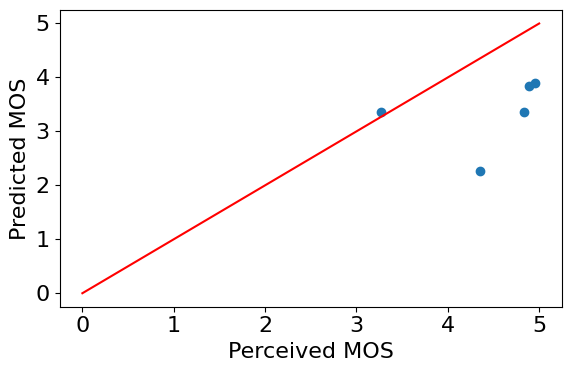

ExtraTreesRegressor


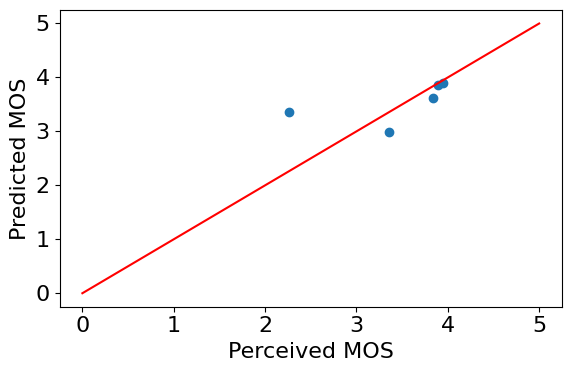

GradientBoostingClassifier


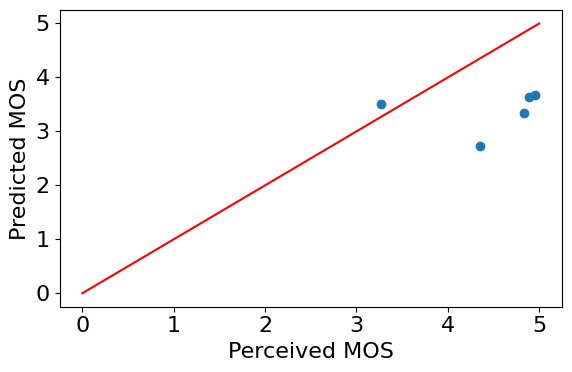

GradientBoostingRegressor


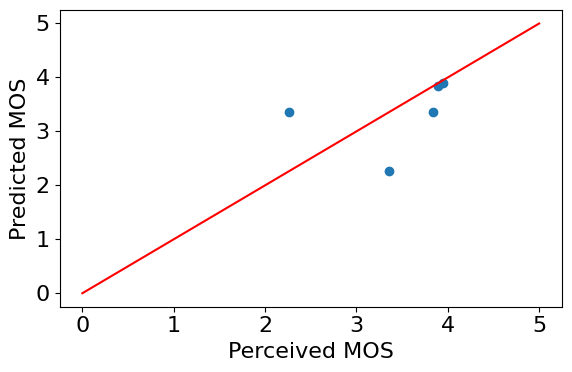

LinearRegression


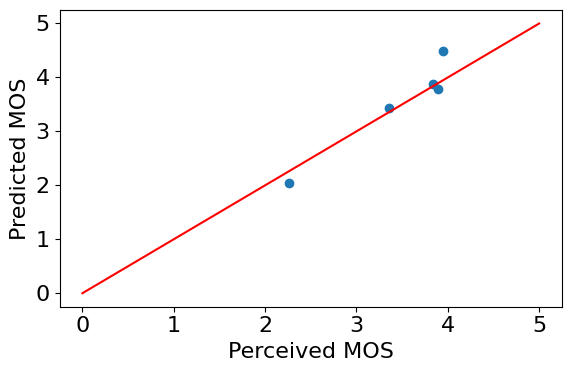

LogisticRegression


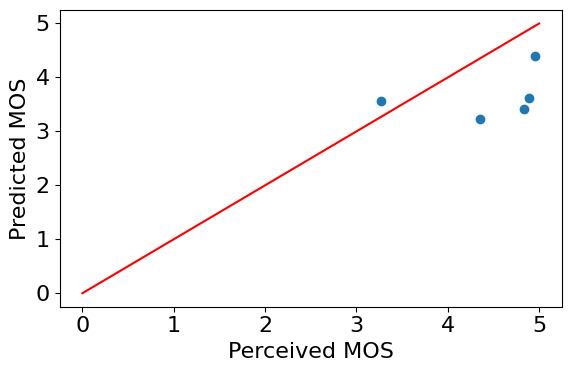

MLPClassifier


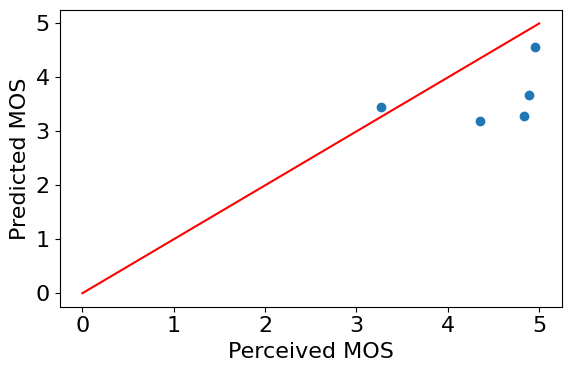

Pipeline


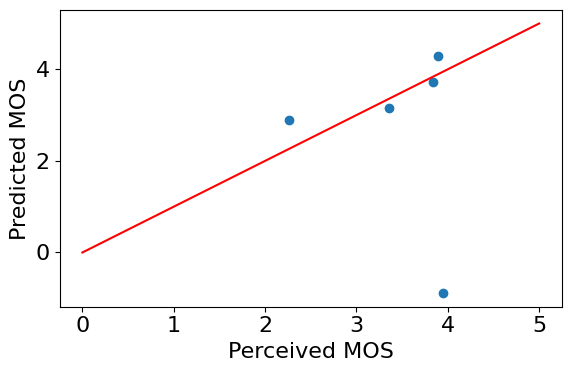

RandomForestClassifier


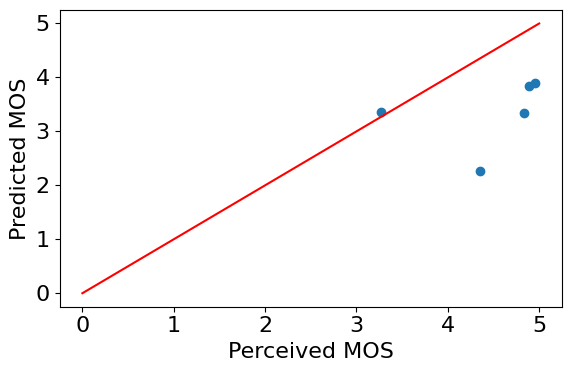

RandomForestRegressor


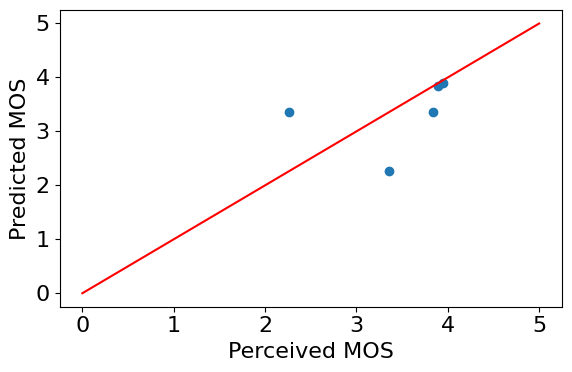

In [21]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

for model, group_content in report.groupby('model'):
    print(model)
    # Generate the scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(group_content['true_mos'], group_content['predicted_mos']) 

    # Add y=x line to the plot
    plt.plot([0, 5], [0, 5], color = 'red')

    # Label the axes
    plt.xlabel('Perceived MOS')
    plt.ylabel('Predicted MOS')
    plt.tight_layout()
    plt.savefig('./figures/predicted_and_true_distribution_' + model + '_DRACO_' + now.strftime("%Y%m%d_%H%M%S") + '.pdf')  
    plt.show()

# Use the ML Model with Partners data to generate QoE results

## Save the models using joblib

In [22]:
from joblib import dump

# After training, save all models, not just the best ones

# best_models = {}
# for model_type in ['classifier', 'regressor']:
#     model_data = model_performance[model_performance.model.str.contains(model_type, case=False)]
#     best_model_name = model_data.sort_values('rmse', ascending=True).iloc[0]['model']
#     best_models[model_type] = best_model_name

# Create directories for saving models and scalers
import os
from datetime import datetime
now = datetime.now()

models_dir = './results_shivi/trained_models'
os.makedirs(models_dir, exist_ok=True)

# Save all the models!
for m in classifier_models:
    # Save model
    model_path = os.path.join(models_dir, f"{m.__class__.__name__}_{now.strftime('%Y%m%d_%H%M%S')}.joblib")
    dump(m, model_path)

    print(f"Saved {m.__class__.__name__} model to: {model_path}")


# Save all the models!
for m in regressor_models:
    # Save model
    model_path = os.path.join(models_dir, f"{m.__class__.__name__}_{now.strftime('%Y%m%d_%H%M%S')}.joblib")
    dump(m, model_path)

    print(f"Saved {m.__class__.__name__} model to: {model_path}")

Saved RandomForestClassifier model to: ./results_shivi/trained_models/RandomForestClassifier_20250702_155338.joblib
Saved LogisticRegression model to: ./results_shivi/trained_models/LogisticRegression_20250702_155338.joblib
Saved GradientBoostingClassifier model to: ./results_shivi/trained_models/GradientBoostingClassifier_20250702_155338.joblib
Saved DecisionTreeClassifier model to: ./results_shivi/trained_models/DecisionTreeClassifier_20250702_155338.joblib
Saved MLPClassifier model to: ./results_shivi/trained_models/MLPClassifier_20250702_155338.joblib
Saved RandomForestRegressor model to: ./results_shivi/trained_models/RandomForestRegressor_20250702_155338.joblib
Saved GradientBoostingRegressor model to: ./results_shivi/trained_models/GradientBoostingRegressor_20250702_155338.joblib
Saved ExtraTreesRegressor model to: ./results_shivi/trained_models/ExtraTreesRegressor_20250702_155338.joblib
Saved LinearRegression model to: ./results_shivi/trained_models/LinearRegression_20250702_15

In [30]:
from joblib import load

model_names = [
    "RandomForestClassifier",
    "LogisticRegression",
    "GradientBoostingClassifier",
    "DecisionTreeClassifier",
    "MLPClassifier",
    "RandomForestRegressor",
    "GradientBoostingRegressor",
    "ExtraTreesRegressor",
    "LinearRegression",
    "Pipeline",
]

# CHANGE THESE FOR USAGE
model_timestamp = "20250702_155338" 
#model_timestamp = now.strftime('%Y%m%d_%H%M%S')
current_model_name = "ExtraTreesRegressor"
model_folder_name = "framerate_qp_bitratembits"

model = load(
    f"./results_shivi/trained_models/{model_folder_name}/{current_model_name}_{model_timestamp}.joblib"
)

# Prepare new data
new_data = pd.DataFrame({
    'frame_rate': [30],
    #'distance': [2.5],
    'quantization_parameter': [14],
    'bitrate_mbits' : [55],
})


prediction = model.predict(new_data)
print(f"Predicted MOS: {prediction[0]:.4f}")

Predicted MOS: 3.1948


### Ericsson